# Compute significance from 2D constraints

This notebook computes the significance of a theoretical prediction or an (new) observed data point given the current 2D (and ND) marginal constraints.

MCMC chains are assumed to be compatible with `getdist` and the 2D (and ND) marginal densities are estimated by KDEs implemented in `getdist.densities.Density2D` (and `getdist.densities.DensityND`)

## Required modules

In [5]:
import warnings
import bisect
import getdist
import numpy as np
from scipy.interpolate import RectBivariateSpline
#import vegas # For ND integration, we need a Monte Carlo integrator
#import vegasflow

## Class and functions

In [15]:
class TensionBarometer:
    r"""
    A class to compute:
    - significance of a point in parameter space (from theory or observation) given the data constraint.
    - tension between two data constraints (within the same theoretical model).
    """
    def __init__(self, *args):
        r"""
        Class constructor.

        Parameters
        ----------
        samples: list[getdist.MCSamples]
            A list consists instance(s) of ``getdist.MCSamples``.
        """
        self.samples = args
        self.significances = None
        if self.samples is None:
            raise Exception(f"Receive empty input. Provide >=1 instance(s) of ``getdist.MCSamples``.")
        elif self.samples == 1:
            warnings.warn(f"Receive a single ``getdist.MCSamples`` as input.", category=Warning)
        else:
            print(f"Receive {len(self.samples)} instances of ``getdist.MCSamples`` as input.")
            
    def compute_point_pdf_2D(self,par_xy,point_xy,normalized=False,**kwargs):
        r"""
        Helper function.
        Return the posterior densities at points corresponding to input parameters `par_xy`.
        
        Parameters
        ----------
        par_xy: list[str]
                The indexes or names of the two parameters, [par_x,par_y].
        point_xy: [float, float]
                The position of the prediction/observation in [par_x, par_y] coordinates.
        normalized: bool, optional
                Whether to normalize the ``getdist.densities.Density2D`` estimate.
                Default to `False`.
        **kwargs:
                Keyword arguments for ``getdist.mcsamples.get2DDensityGridData()`` and ``scipy.interpolate.RectBivariateSpline``.
        """
        point_pdf_2D=[]
        for sample in self.samples:
            density2D = sample.get2DDensity(par_xy[0],par_xy[1],normalized=normalized,**kwargs)
            interpolator = RectBivariateSpline(density2D.x, density2D.y, density2D.P,**kwargs)
            point_pdf_2D.append(interpolator.ev(point_xy[0], point_xy[1]))
        return point_pdf_2D
    
    def get_density_contours_2D(self,par_xy,contour_levels,normalized=False,**kwargs):
        r"""
        Helper function.
        Return the posterior densities corresponding to input `contour_levels`.
        
        Parameters
        ----------
        par_xy: list[str]
                The indexes or names of the two parameters, [par_x,par_y].
        contour_levels: list[float]
                The contour levels, i.e. confidence limits per each sample.
        normalized: bool, optional
                Whether to normalize the ``getdist.densities.Density2D`` estimate.
                Default to `False`.
        **kwargs:
                Keyword arguments for ``getdist.mcsamples.get2DDensity()``.
        """
        density_contours_2D=[]
        for sample in self.samples:
            density2D = sample.get2DDensity(par_xy[0],par_xy[1],normalized=normalized,**kwargs)
            density_contours_2D.append(density2D.getContourLevels(contours=contour_levels))
        return np.asarray(density_contours_2D).reshape(len(self.samples),len(contour_levels))
    
    def compute_posterior_density_ratio_2D(self,par_xy,point_xy,normalized=False,**kwargs):
        r"""
        Main function.
        Compute the ratio of the posterior density at `point_xy` over that at the MAP point.
        Require a `BestFit` object loaded from a `.minimum` or `.bestfit` file.
        Those are outputs from a posterior/likelihood minimization run on top of the MCMC chain.
        
        Parameters
        ----------
        par_xy: list[str]
                The indexes or names of the two parameters, [par_x,par_y].
        point_xy: [float, float]
                The position of the prediction/observation in [par_x, par_y] coordinates.
        normalized: bool, optional
                Whether to normalize the ``getdist.densities.Density2D`` estimate.
                Default to `False`.
        **kwargs:
                Keyword arguments for ``self.compute_point_pdf_2D()`` and ``getdist.mcsamples.get2DDensity()``
        """
        point_pdf_2Ds = self.compute_point_pdf_2D(par_xy,point_xy,normalized=normalized,**kwargs)
        MAP_pdf_2Ds = []
        for sample in self.samples:
            try:
                MAP_pdf_2D = self.compute_point_pdf_2D(par_xy,\
                    [sample.getBestFit().getParamDict()[par_xy[0]],sample.getBestFit().getParamDict()[par_xy[1]]],\
                    normalized=normalized,**kwargs)
            except FileNotFoundError as err:
                warnings.warn("Cannot load `BestFit` from file. No `.minimum` or `.bestfit` file found. Use a *noisy* estimate of MAP from chain.", UserWarning)
                density2D = sample.get2DDensity(par_xy[0],par_xy[1],normalized=normalized,**kwargs)
                MAP_pdf_2D = density2D.P.max()
            MAP_pdf_2Ds.append(MAP_pdf_2D)
        return [(point_pdf_2D/MAP_pdf_2D)\
                for point_pdf_2D,MAP_pdf_2D in zip(point_pdf_2Ds,MAP_pdf_2Ds)]
    
    def compute_Bayes_factor_SD_ratio_2D(self,par_xy,point_xy,prior_xy=1.0,normalized=False,**kwargs):
        r"""
        Main function.
        Compute the Bayes factor from MCMC chains through the Savage-Dickey density ratio.
        Note that S-D estimator only works for nested models.
        See, e.g. [here](https://statproofbook.github.io/P/bf-sddr.html)
        
        Parameters
        ----------
        par_xy: list[str]
                The indexes or names of the two parameters, [par_x,par_y].
        point_xy: [float, float]
                The position of the prediction/observation in [par_x, par_y] coordinates.
        prior_xy: float, optional
                Prior density at point_xy. Default to `1.0`.
        normalized: bool, optional
                Whether to normalize the ``getdist.densities.Density2D`` estimate.
                Default to `False`.
        **kwargs:
                Keyword arguments for ``self.compute_point_pdf_2D()``.
        """
        return np.log10(self.compute_point_pdf_2D(par_xy,point_xy,normalized=normalized,**kwargs)/prior_xy)
    
    @staticmethod
    def _bisect_search(arr,point):
        r"""
        Helper function.
        Search the array for the closest *higher* element, by bisection.
        Scale as O(log n), more efficient for large array.
        
        Parameters
        ----------
        arr: array_like
            The input array. Assumed to be sorted in ascending order.
        point: float
            The input point value.
        """
        return len(arr) - bisect.bisect_left(arr, point) - 1

    def compute_posterior_above_point_2D(self,par_xy,point_xy,normalized=False,inner_CL=1e-6,outter_CL=1.0,n_contours=100,convergence_threshold=1e-4,**kwargs):
        r"""
        Main function.
        Compute the significance of the prediction or observation given the 2D posterior density.
        Return the integral of the posterior density over the area with P(`par_xy`|data)>=P(`point_xy`|data).
        
        Parameters
        ----------
        par_xy: list[str]
                The indexes or names of the two parameters, [par_x,par_y].
        point_xy: [float, float]
                The position of the prediction/observation in [par_x, par_y] coordinates.
        contour_levels: list[float]
                The contour levels, i.e. confidence limits per each sample.
        normalized: bool, optional
                Whether to normalize the ``getdist.densities.Density2D`` estimate.
                Default to `False`.
        inner_CL, outter_CL: float, float, optional.
                Initial inner and outter confidence levels to begin searching.
                Default to `1e-6` and `1.0` of posterior mass, respectively.
                If you have a good idea of P([point_x,point_y]), adjust these two accordingly to improve efficiency.
        n_contours: int, optional
                Number of contour levels to define.
                Default to `100`.
        convergence_threshold: float, optional.
                Threshold for convergence of P search
        **kwargs:
                Keyword arguments for ``self.compute_point_pdf_2D()`` and ``self.get_density_contours_2D``
        """ 
        point_pdf_2Ds = self.compute_point_pdf_2D(par_xy,point_xy,normalized=normalized,**kwargs)
        contour_levels = np.linspace(inner_CL,outter_CL,n_contours)
        density_contours_2Ds = self.get_density_contours_2D(par_xy,contour_levels=contour_levels)
        sig2Ds = []
        for p,pdf2D_point in enumerate(point_pdf_2Ds):
            # Initialize distance from CL to the point
            distance = density_contours_2Ds[p][0] - pdf2D_point
            if distance < 0:
                raise ValueError(f"Input point is within the innermost contour. Try define initial contours starting closer from the peak. Current distance P={distance}.")
            else: 
                try:
                    while distance > convergence_threshold:
                        # Find closest CL with P([par_x,par_y])>=P([point_x,point_y])
                        CL_index = self._bisect_search(np.flip(density_contours_2Ds[p, :]), pdf2D_point)
                        # Check whether CL_index corresponds to the first or last element of contour_levels
                        if CL_index == 0:
                            raise IndexError(f"Input point is closest to the innermost contour. Try define initial contours starting closer from the peak and/or finer contours. Current distance P={distance}.")
                        elif CL_index == n_contours-1:
                            raise IndexError(f"Input point is closest to the outtermost contour. Try define intial contours reaching further out to the tail. Current distance P={distance}.")
                        else:
                            # Update inner_CL and outter_CL
                            inner_CL = contour_levels[CL_index]
                            outter_CL = contour_levels[CL_index+1]
                            # Update CLs - Zoom in the vicinity of point_xy
                            contour_levels = np.linspace(inner_CL,outter_CL,n_contours)
                            # Compute new densities at updated CLs
                            density_contours_2Ds = self.get_density_contours_2D(par_xy, contour_levels=contour_levels,**kwargs)
                            # Update distance
                            distance = density_contours_2Ds[p,0] - pdf2D_point
                    print("Convergence condition reached.")
                    sig2Ds.append(contour_levels[CL_index])
                except ValueError as e:
                    print(f"Convergence condition never met.")
        return sig2Ds
    
    def print_latex_table(self, sample_names=None,sample_significances=None):
        """
        Return a LaTeX table of sample names and their corresponding significance values.
        Compute and fill significances before calling this function.
        
        Parameters
        ----------
        
        sample_names:
            Names of samples/data.
            Either pass here as input or grab from ``getdist.mcsamples``.
        
        sample_significances: float, optional.
            Significances of null hypothesis rejections per each sample/data.
            Either pass here as input or pre-compute and store in ``self.significances``.
        """
        if len(self.samples) != len(self.significances):
            raise ValueError("Number of samples and significances must be the same.")
        if sample_names is None:
            warnings.warn("No input sample names. Try to grab names from ``getdist.mcsamples``.",category=Warning)
            sample_names = []
            for sample in self.samples:
                name=sample.getName().replace("_", r"\textunderscore ")
                sample_names.append(name)
        if sample_significances is None:
            warnings.warn("No input sample significances. Try to grab names from ``self.significances``.",category=Warning)
            sample_significances = self.significances
        # Table header - 2 columns [sample name | significance]
        print(r"\begin{table}")
        print(r"\begin{center}")
        print(r"\begin{tabular}{|l|c|}")
        print(r"\hline")
        print(r"Data & Significance \\")
        print(r"\hline")

        # Table values - individual rows correspond to individual samples
        for sample_name, sample_significance in zip(sample_names, sample_significances):
            print(f"{sample_name} & {sample_significance * 100:.1f}% \\")

        # Table footer
        print(r"\hline")
        print(r"\end{tabular}")
        print(r"\label{tab:data_significance}")
        print(r"\end{center}")
        print(r"\end{table}")

## Usage

### Data path

In [16]:
chain_path='./data/GammaPrimefree_Omegakfixed_planck2018_highl_TTTEEE_lowl_TTEE_lensing_BAO_des_fsigma8'

### Computation

Load samples.

In [17]:
settings={'ignore_rows': '0.3'}
getdist_samples = getdist.mcsamples.loadMCSamples(file_root=chain_path,ini=None,settings=settings)
tension = TensionBarometer(getdist_samples)

Receive 1 instances of ``getdist.MCSamples`` as input.


Compute significance.

In [18]:
fid_point=[0.55,0.0]
tension.significances = tension.compute_posterior_above_point_2D(['gamma0','gamma1'],fid_point,\
                                normalized=False,\
                                inner_CL=0.99,n_contours=100,convergence_threshold=1e-6)

Convergence condition reached.


In [19]:
tension.compute_posterior_above_point_2D(['gamma0','gamma1'],fid_point,\
                                normalized=False,\
                                inner_CL=0.99,n_contours=100,convergence_threshold=1e-6)

Convergence condition reached.


[0.9975005127285507]

In [20]:
print(tension.significances)
tension.print_latex_table()

[0.9975005127285507]
\begin{table}
\begin{center}
\begin{tabular}{|l|c|}
\hline
Data & Significance \\
\hline
GammaPrimefree\textunderscore Omegakfixed\textunderscore planck2018\textunderscore highl\textunderscore TTTEEE\textunderscore lowl\textunderscore TTEE\textunderscore lensing\textunderscore BAO\textunderscore des\textunderscore fsigma8 & 99.8% \
\hline
\end{tabular}
\label{tab:data_significance}
\end{center}
\end{table}


/tmp/ipykernel_2221903/1161401248.py:228: Warning: No input sample names. Try to grab names from ``getdist.mcsamples``.
  warnings.warn("No input sample names. Try to grab names from ``getdist.mcsamples``.",category=Warning)
/tmp/ipykernel_2221903/1161401248.py:234: Warning: No input sample significances. Try to grab names from ``self.significances``.
  warnings.warn("No input sample significances. Try to grab names from ``self.significances``.",category=Warning)


### Visual inspection

Check whether the identified CL intersects the input point.

In [21]:
import matplotlib
from matplotlib import pyplot as plt
from getdist import plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['legend.framealpha']=0.
matplotlib.style.use('Minh_paper_style')
cmap=matplotlib.colormaps['viridis']

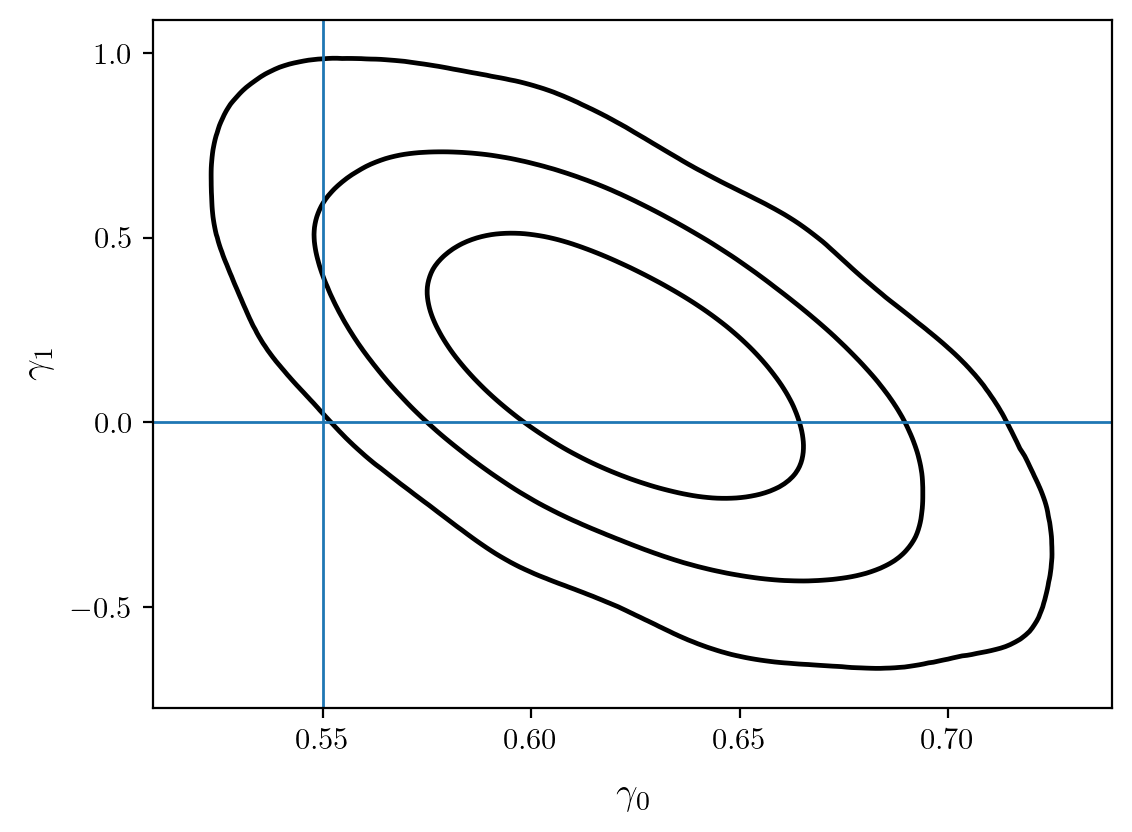

In [23]:
g = plots.get_single_plotter()
samples=getdist.mcsamples.loadMCSamples(file_root=chain_path,ini=None,settings=settings)
samples.updateSettings({'contours': [0.68, 0.95, tension.significances[0]]})
g.settings.num_plot_contours = 3
g.plot_2d(samples, 'gamma0', 'gamma1');
ax=g.subplots[0,0]
ax.axhline(y=0.)
ax.axvline(x=0.55)